<div class="alert alert-block alert-info">
<h3>Student Information</h3> Please provide information about yourself.<br>
<b>Name1</b>: George Zakka<br>
<b>Name2 (optional) </b>:<br>
<b>NetID 1</b>: gnz5<br>
<b>NetID 2 (optional)</b>:<br>
<b>Recitation1 (Mon-1/Fri-2)</b>: Mon-1<br>
<b>Recitation2 (Mon-1/Fri-2) - optional </b>:<br>
<b>Notes to Grader</b> (optional):<br>
<br><br>
<b>IMPORTANT</b>
Your work will not be graded withour your initials below<br>
I certify that this lab represents my own work and I have read the RU academic intergrity policies at<br>
<a href="https://www.cs.rutgers.edu/academic-integrity/introduction">https://www.cs.rutgers.edu/academic-integrity/introduction </a><br>
<b>Initials</b>: GZ     


<h3>Grader Notes</h3>
<b>Your Grade<b>:<br>
<b>Grader Initials</b>:<br>
<b>Grader Comments</b> (optional):<br>
</div>

### CS 439 - Introduction to Data Science
### Spring 2019

# Midsemester Project : Twitter Analysis

### Due Date : Friday March 15, 2019 by 11:59 PM.###


### About this project
The goal of this mid-semester project is to work with Twitter API to analyze tweets from a person, in this case, President Donald Trump.  @RealDonaldTrump tweets provide a great opportunity to understand how online media can be used to communicate over the traditional media. Moreoover, Trump tweets has become so consequential, they actually can move the stock market on short term. Short term investors must now always pay attention to Trump tweets before trading. 

We hope this project will be fun as we can analyze range of emotions, hope, controversy, vagueness that are part of Trump tweets. We are interested in seeing what conclusions you can draw from US Presidents tweets. 
* DISCLAIMER: This project is not designed with any bias in mind. Note that we could pick either candiadate (Hillary Clinton or Donald Trump) or anyone else to do the same analysis. We hope your analysis is objective, independent of any political bias you may have. As Data Scientists, it is our responsiblity to do independent analysis of the data we try to understand. You should follow data and interpret w/o any bias.


In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import json

pd.set_option('max_colwidth', 280)

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re
import tweepy

In [77]:
import json
key_file = 'keys.json'
with open(key_file) as f:
    keys = json.load(f)

In [78]:
import tweepy
from tweepy import TweepError
import logging

try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

Your username is: gnz51


In [79]:
from pathlib import Path
import json

ds_tweets_save_path = "data/RutgersU_recent_tweets.json"   # need to get this file

if not Path(ds_tweets_save_path).is_file():
    example_tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id="RutgersU", 
                                             tweet_mode='extended').items()]
    with open(ds_tweets_save_path, "w") as f:        
        json.dump(example_tweets, f)
with open(ds_tweets_save_path, "r") as f:
    example_tweets = json.load(f)

In [80]:
# Looking at one tweet object, which has type Status: 
from pprint import pprint # ...to get a more easily-readable view.
pprint(example_tweets[0])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Fri Mar 22 20:58:03 +0000 2019',
 'display_text_range': [0, 139],
 'entities': {'hashtags': [{'indices': [27, 35], 'text': 'Rutgers'},
                           {'indices': [99, 112], 'text': 'MatchDay2019'}],
              'symbols': [],
              'urls': [],
              'user_mentions': [{'id': 441835630,
                                 'id_str': '441835630',
                                 'indices': [3, 14],
                                 'name': 'Rutgers Biomedical and Health '
                                         'Sciences',
                                 'screen_name': 'RutgersBHS'}]},
 'favorite_count': 0,
 'favorited': False,
 'full_text': 'RT @RutgersBHS: Last week, #Rutgers medical students learned '
              'their residency placements as part of #MatchDay2019. \n'
              '\n'
              'Take a look at some of…',
 'geo': None,
 'id': 1109197569601740800,
 'id_str': '110919756960174

In [81]:
def load_keys(path):
    with open(key_file) as f:
        keys = json.load(f)
    return keys
#keys = load_keys('keys.json')

In [82]:
import math
def download_recent_tweets_by_user(user_account_name, keys):
    try:
        auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
        auth.set_access_token(keys["access_token"], keys["access_token_secret"])
        api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())
        num_downloads = 3000
        num_calls = math.ceil(num_downloads/200)
        print('trying to download ' + str(num_downloads) + ' tweets')
        tweets = list()
        for i in range(num_calls):
            tweets += api.user_timeline(user_account_name, count=num_downloads)
        print('downloaded ' + str(len(tweets)) + ' tweets')
    except TweepError as e:
        logging.warning("There was a Tweepy error. Double check your API keys and try again.")
        logging.warning(e)
    file = "data/recent_tweets.txt"
    f = open(file, "a")
    f.write(json.dumps(tweets))
    f.close()
    return tweets
#tweets = download_recent_tweets_by_user('realDonaldTrump', keys)

In [83]:
def load_tweets(path):
    f = open(path, "r")
    content = f.read()
    f.close()
    content_as_dict = json.loads(content)
    return content_as_dict
#loaded_tweets = load_tweets("data/recent_tweets.txt")

In [84]:
import os
def get_tweets_with_cache(user_account_name, keys_path):
    keys = load_keys(keys_path)
    
    cwd = os.getcwd()
    saved_tweets = "data/recent_tweets.txt"
    full_path = os.path.join(cwd, saved_tweets)
    
    # tweets file doesn't exist or is empty, download tweets
    if (not Path(saved_tweets).is_file()) or (os.path.getsize(full_path) == 0):
        print('downloading tweets from: ' + user_account_name)
        tweets = download_recent_tweets_by_user(user_account_name, keys)
    # tweet file exists and is not empty, pull from cache
    else:
        print('loading tweets from cache for ' + user_account_name)
        tweets = load_tweets(saved_tweets)
    print('returning ' + str(len(tweets)) + ' tweets')
    return tweets
#get_tweets_with_cache('realDonaldTrump', 'keys.json')

In [85]:
trump_tweets = get_tweets_with_cache("realdonaldtrump", key_file)
print("Number of tweets downloaded:", len(trump_tweets))

loading tweets from cache for realdonaldtrump
returning 3000 tweets
Number of tweets downloaded: 3000


In [90]:
import time
from datetime import date

#day_of_week, month, day, time, tzone, year = trump_tweets[0]['created_at'].split(' ')
#   [0]        [1]  [2]    [3]   [4]    [5]
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,\
          'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

first = trump_tweets[0]['created_at'].split(' ')
min_date = date(int(first[5]), months[first[1]], int(first[2]))

for i in range(1, len(trump_tweets)):
    d = trump_tweets[i]['created_at'].split(' ')
    curr = date(int(d[5]), months[d[1]], int(d[2]))
    if(curr < min_date):
        min_date = curr
print(min_date)

2019-03-09


In [91]:
old_tweets = load_tweets('data/realdonaldtrump_tweets/2016-2017.json')
ids = []
all_tweets = []

for tw2 in old_tweets:
    if tw2['id'] not in ids:
        ids.append(tw2['id'])
        all_tweets.append(tw2) 

for tw1 in trump_tweets:
    if tw1['id'] not in ids:
        ids.append(tw1['id'])
        all_tweets.append(tw1)

In [92]:
df_trump = pd.DataFrame.from_records(all_tweets, index='id')
df_trump = df_trump[['created_at', 'source', 'text', 'retweet_count']]
df_trump.rename(columns={"created_at": "time"}, inplace=True)
df_trump = df_trump.fillna('/')
df_trump['time'] = pd.to_datetime(df_trump['time'], infer_datetime_format=True).values.astype('<M8[ns]')
df_trump.head(5)

,time,source,text,retweet_count
id,,,,
947824196909961216,2018-01-01 13:37:52,Twitter for iPhone,"Will be leaving Florida for Washington (D.C.) today at 4:00 P.M. Much work to be done, but it will be a great New Year!",8237
947810806430826496,2018-01-01 12:44:40,Twitter for iPhone,"Iran is failing at every level despite the terrible deal made with them by the Obama Administration. The great Iranian people have been repressed for many years. They are hungry for food &amp; for freedom. Along with human rights, the wealth of Iran is being looted. TIME FOR ...",14595
947802588174577664,2018-01-01 12:12:00,Twitter for iPhone,"The United States has foolishly given Pakistan more than 33 billion dollars in aid over the last 15 years, and they have given us nothing but lies &amp; deceit, thinking of our leaders as fools. They give safe haven to the terrorists we hunt in Afghanistan, with little help. ...",49566
947614110082043904,2017-12-31 23:43:04,Twitter for iPhone,"HAPPY NEW YEAR! We are MAKING AMERICA GREAT AGAIN, and much faster than anyone thought possible!",35164
947592785519173637,2017-12-31 22:18:20,Twitter for iPhone,"As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!",39428


In [95]:
df_trump['source'].unique()

array(['Twitter for iPhone', 'Media Studio', 'Twitter for iPad',
       'Twitter Web Client', 'Twitter Ads', 'Twitter for Android',
       'Periscope', 'TweetDeck', 'Instagram', 'Mobile Web (M5)',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Twitter Media Studio</a>'],
      dtype=object)

In [96]:
df_trump['source'] = df_trump['source'].str.replace('</a>', '').str.replace('^<a.*>', '', regex=True)

In [97]:
from datetime import datetime
ELEC_DATE = datetime(2016, 11, 8)
INAUG_DATE = datetime(2017, 1, 20)
assert set(df_trump[(df_trump['time'] > ELEC_DATE) & (df_trump['time'] < INAUG_DATE) ]['source'].unique()) == set(['Twitter Ads',
 'Twitter Web Client',
 'Twitter for Android',
 'Twitter for iPhone'])

Text(0, 0.5, 'Number of Tweets')

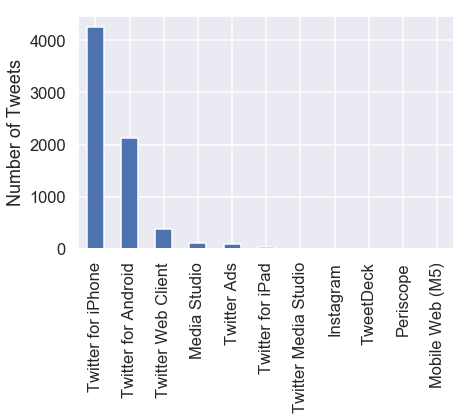

In [99]:
df_trump['source'].value_counts().plot(kind="bar")
plt.ylabel("Number of Tweets")

In [101]:
df_trump['est_time'] = (
    df_trump['time'].dt.tz_localize("UTC") # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
df_trump.head()

,time,source,text,retweet_count,est_time
id,,,,,
947824196909961216,2018-01-01 13:37:52,Twitter for iPhone,"Will be leaving Florida for Washington (D.C.) today at 4:00 P.M. Much work to be done, but it will be a great New Year!",8237,2018-01-01 08:37:52-05:00
947810806430826496,2018-01-01 12:44:40,Twitter for iPhone,"Iran is failing at every level despite the terrible deal made with them by the Obama Administration. The great Iranian people have been repressed for many years. They are hungry for food &amp; for freedom. Along with human rights, the wealth of Iran is being looted. TIME FOR ...",14595,2018-01-01 07:44:40-05:00
947802588174577664,2018-01-01 12:12:00,Twitter for iPhone,"The United States has foolishly given Pakistan more than 33 billion dollars in aid over the last 15 years, and they have given us nothing but lies &amp; deceit, thinking of our leaders as fools. They give safe haven to the terrorists we hunt in Afghanistan, with little help. ...",49566,2018-01-01 07:12:00-05:00
947614110082043904,2017-12-31 23:43:04,Twitter for iPhone,"HAPPY NEW YEAR! We are MAKING AMERICA GREAT AGAIN, and much faster than anyone thought possible!",35164,2017-12-31 18:43:04-05:00
947592785519173637,2017-12-31 22:18:20,Twitter for iPhone,"As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!",39428,2017-12-31 17:18:20-05:00


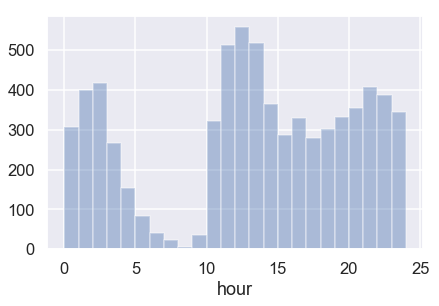

In [102]:
df_trump['hour'] = df_trump['time'].apply(\
                   lambda ts: float(ts.hour) + float(ts.minute)/60 + float(ts.second)/3600)
sns.distplot(df_trump['hour'], bins=24, kde=False);

Use this data along with the seaborn `distplot` function to examine the distribution over hours of the day in eastern time that trump tweets on each device for the 2 most commonly used devices.  Your plot should look somewhat similar to the following. 
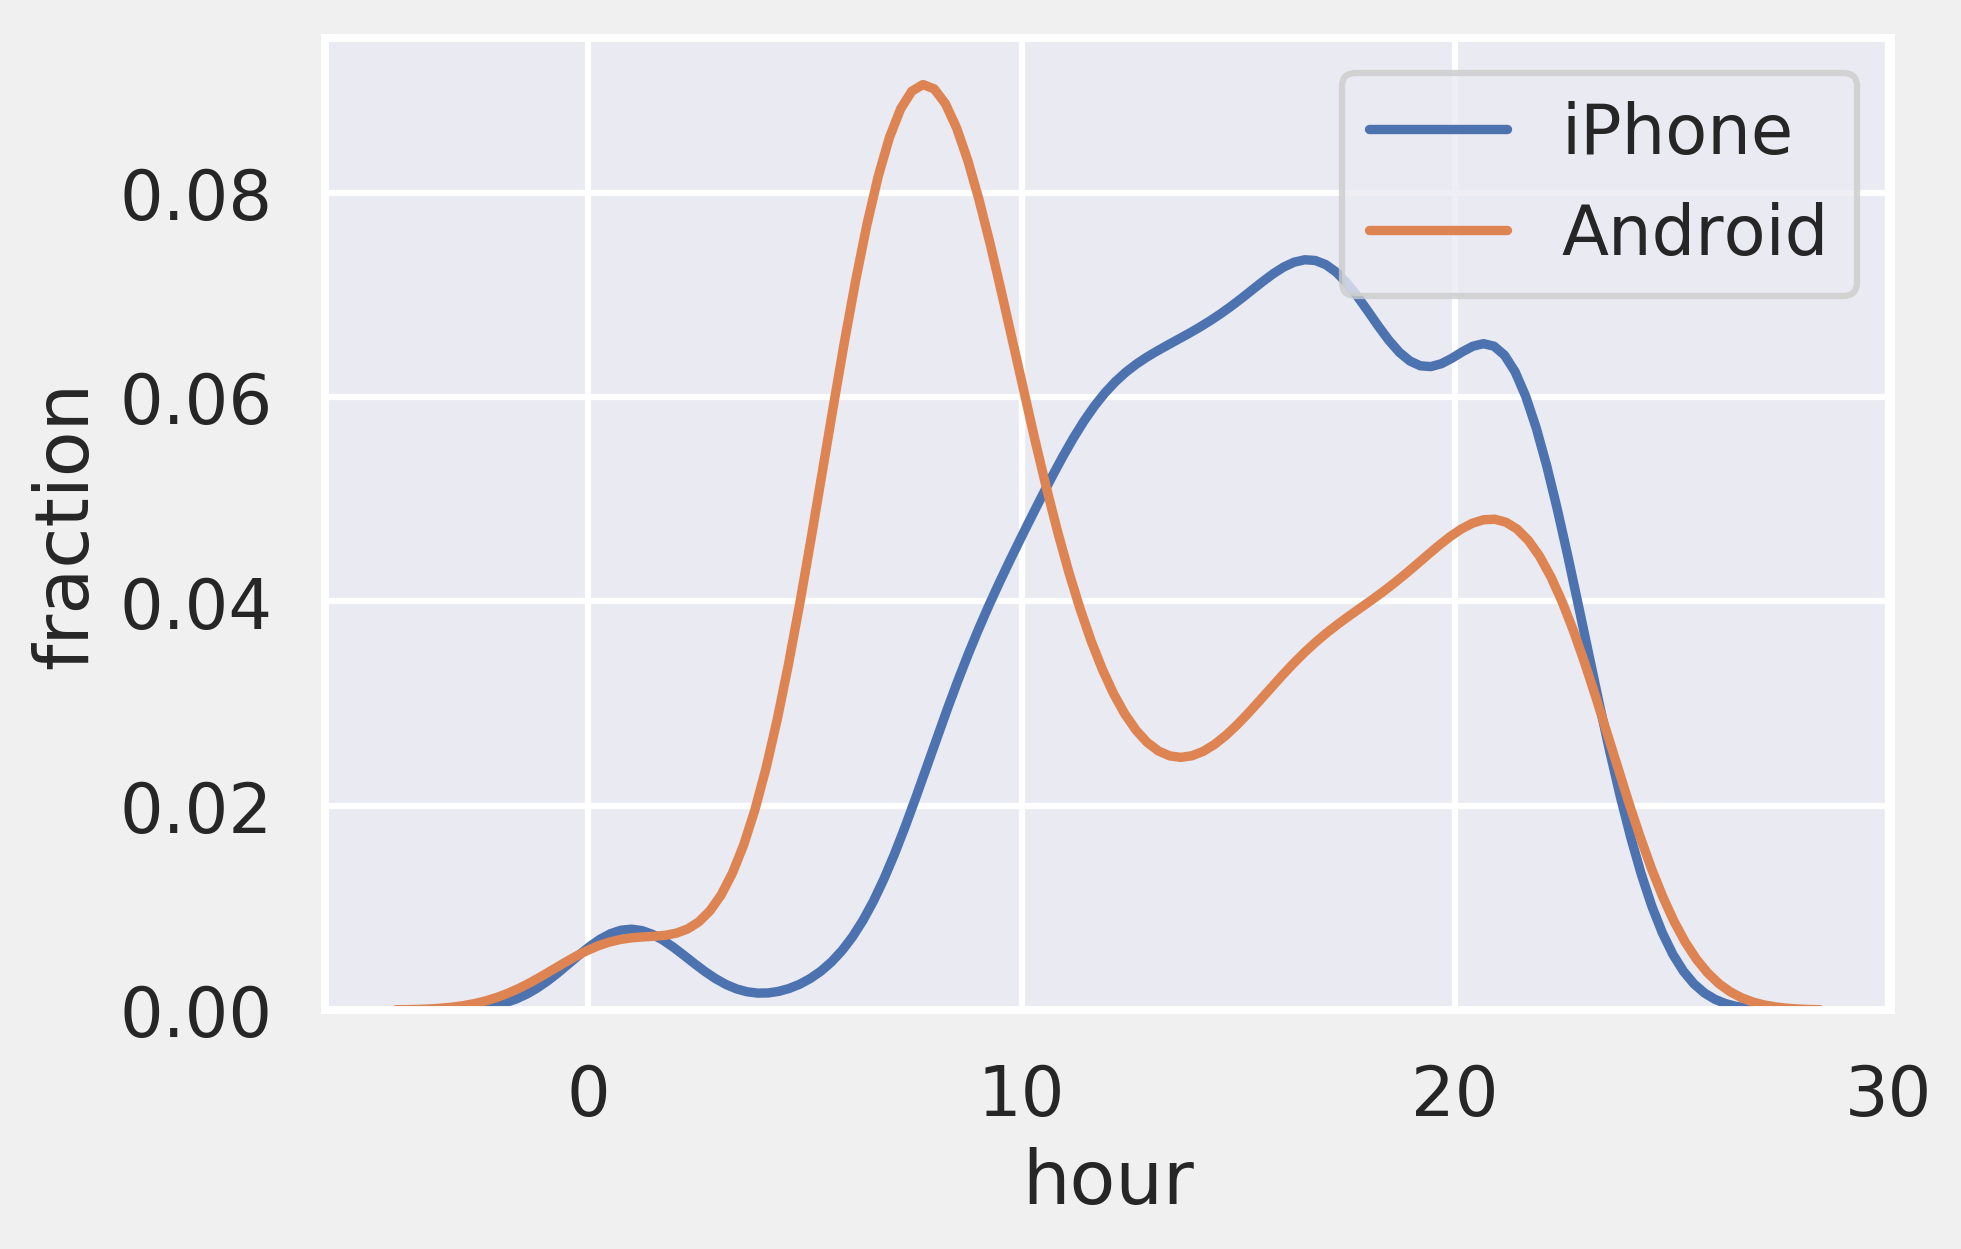


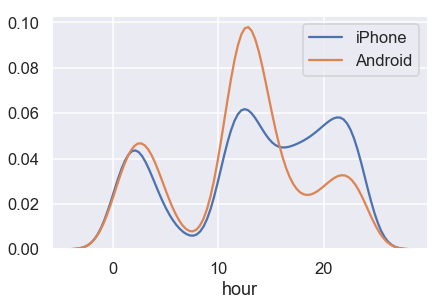

In [104]:
iphone = df_trump[df_trump['source'] == 'Twitter for iPhone']['hour']
android = df_trump[df_trump['source'] == 'Twitter for Android']['hour']
fig, ax = plt.subplots()
sns.distplot(iphone, bins=24, kde=True, hist=False, ax=ax, kde_kws={"label": "iPhone"})
sns.distplot(android, bins=24, kde=True, hist=False, ax=ax, kde_kws={"label": "Android"});

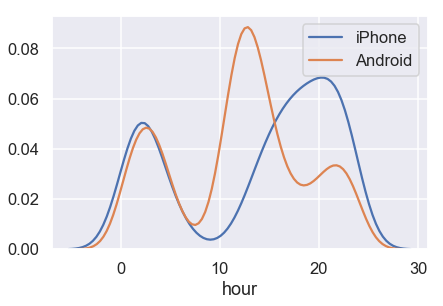

In [105]:
iphone2 = df_trump[(df_trump['source'] == 'Twitter for iPhone') & (df_trump['time'].dt.date.apply(lambda x: x.year) == 2016)]['hour']
android2 = df_trump[(df_trump['source'] == 'Twitter for Android') & (df_trump['time'].dt.date.apply(lambda x: x.year) == 2016)]['hour']
fig, ax = plt.subplots()
sns.distplot(iphone2, bins=24, kde=True, hist=False, ax=ax, kde_kws={"label": "iPhone"})
sns.distplot(android2, bins=24, kde=True, hist=False, ax=ax, kde_kws={"label": "Android"});

# we can infer whether or not the iphone was used by his staff if tweets often during
# time when trump is visible doing something else. For example, if he usually gives a press 
# conference at noon, then it's almost certainly not him because there is a spike of tweets
# around noon

In [106]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

df_trump['year'] = df_trump['time'].apply(year_fraction)

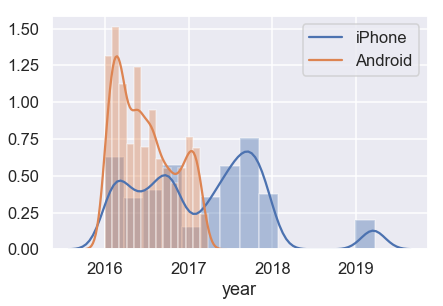

In [107]:
iphone3 = df_trump[df_trump['source'] == 'Twitter for iPhone']['year']
android3 = df_trump[df_trump['source'] == 'Twitter for Android']['year']
fig, ax = plt.subplots()
sns.distplot(iphone3, bins=14, kde=True, hist=True, ax=ax, kde_kws={"label": "iPhone"})
sns.distplot(android3, bins=14, kde=True, hist=True, ax=ax, kde_kws={"label": "Android"});

In [108]:
print(''.join(open("vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



In [109]:
df_sent = pd.read_csv('vader_lexicon.txt', index_col=0, delim_whitespace=True, header=None, error_bad_lines=False)
df_sent.rename(columns={1: "polarity"}, inplace=True)
df_sent = df_sent[['polarity']];

b'Skipping line 6: expected 13 fields, saw 15\nSkipping line 1259: expected 13 fields, saw 14\nSkipping line 2864: expected 13 fields, saw 14\nSkipping line 5906: expected 13 fields, saw 14\n'


In [110]:
assert isinstance(df_sent, pd.DataFrame)
assert df_sent.shape[0] > 7000
assert df_sent.shape[1] == 1
for i in ['paranoids', 'pardon', 'pardoned', 'pardoning', 'pardons']:
    assert df_sent.index.contains(i) == True
assert np.allclose(df_sent['polarity'].head(), [-1.5, -0.4, -1.5, -0.4, -0.7])

In [111]:
df_trump['text'] = df_trump['text'].apply(str.lower)

In [113]:
def remove_punc(s):
    regex = re.compile('[^a-zA-Z]')
    return regex.sub(' ', s)

df_trump['no_punc'] = df_trump['text'].apply(remove_punc)

In [115]:
tidy_format = df_trump['no_punc'].str.split(expand=True).stack().reset_index(level=1)\
                                 .rename(columns={"level_1": "num", 0: "word"});
print(tidy_format.head(5))
print(tidy_format.loc['947824196909961216'])

                    num     word
id                              
947824196909961216    0     will
947824196909961216    1       be
947824196909961216    2  leaving
947824196909961216    3  florida
947824196909961216    4      for
                    num        word
id                                 
947824196909961216    0        will
947824196909961216    1          be
947824196909961216    2     leaving
947824196909961216    3     florida
947824196909961216    4         for
947824196909961216    5  washington
947824196909961216    6           d
947824196909961216    7           c
947824196909961216    8       today
947824196909961216    9          at
947824196909961216   10           p
947824196909961216   11           m
947824196909961216   12        much
947824196909961216   13        work
947824196909961216   14          to
947824196909961216   15          be
947824196909961216   16        done
947824196909961216   17         but
947824196909961216   18          it
9478241969099

In [117]:
df_sent_copy = df_sent.copy(deep=True)
tidy_format_copy = tidy_format.copy(deep=True)
merged = pd.merge(tidy_format_copy, df_sent_copy, how='inner', left_on='word', right_index=True)
out = merged.groupby(level=0).sum()['polarity']
df_trump['polarity'] = out

In [119]:
print('Most negative tweets:')
for t in df_trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   horrible and cowardly terrorist attack on innocent and defenseless worshipers in egypt. the world cannot tolerate terrorism, we must defeat them militarily and discredit the extremist ideology that forms the basis of their existence!

   "@fiiibuster: @jeffzeleny pathetic - you have no sufficient evidence that donald trump did not suffer from voter fraud, shame! bad reporter.

   democrat jon ossoff would be a disaster in congress. very weak on crime and illegal immigration, bad for jobs and wants higher taxes. say no

   nyc terrorist was happy as he asked to hang isis flag in his hospital room. he killed 8 people, badly injured 12. should get death penalty!

   yet another terrorist attack today in israel -- a father, shot at by a palestinian terrorist, was killed while:
https://t.co/cv1hzkvbit


In [120]:
print('Most positive tweets:')
for t in df_trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   thank you to linda bean of l.l.bean for your great support and courage. people will support you even more now. buy l.l.bean. @lbperfectmaine

   it was my great honor to celebrate the opening of two extraordinary museums-the mississippi state history museum &amp; the mississippi civil rights museum. we pay solemn tribute to our heroes of the past &amp; dedicate ourselves to building a future of freedom, equality, justice &amp; peace. https://t.co/5akgvpv8aa

   rt @ivankatrump: 2016 has been one of the most eventful and exciting years of my life. i wish you peace, joy, love and laughter. happy new…

   melania, our great and very hard working first lady, who truly loves what she is doing, always thought that “if you run, you will win.” she would tell everyone that, “no doubt, he will win.” i also felt i would win (or i would not have run) - and country is doing great!

   "@pauladuvall2: we're all enjoying you, as well, mr. t.! you've inspired hope and a posit

### Task 4.7
Plot the distribution of tweet sentiments broken down by whether the text of the tweet contains `nyt` or `fox`.  Then in the box below comment on what we observe?

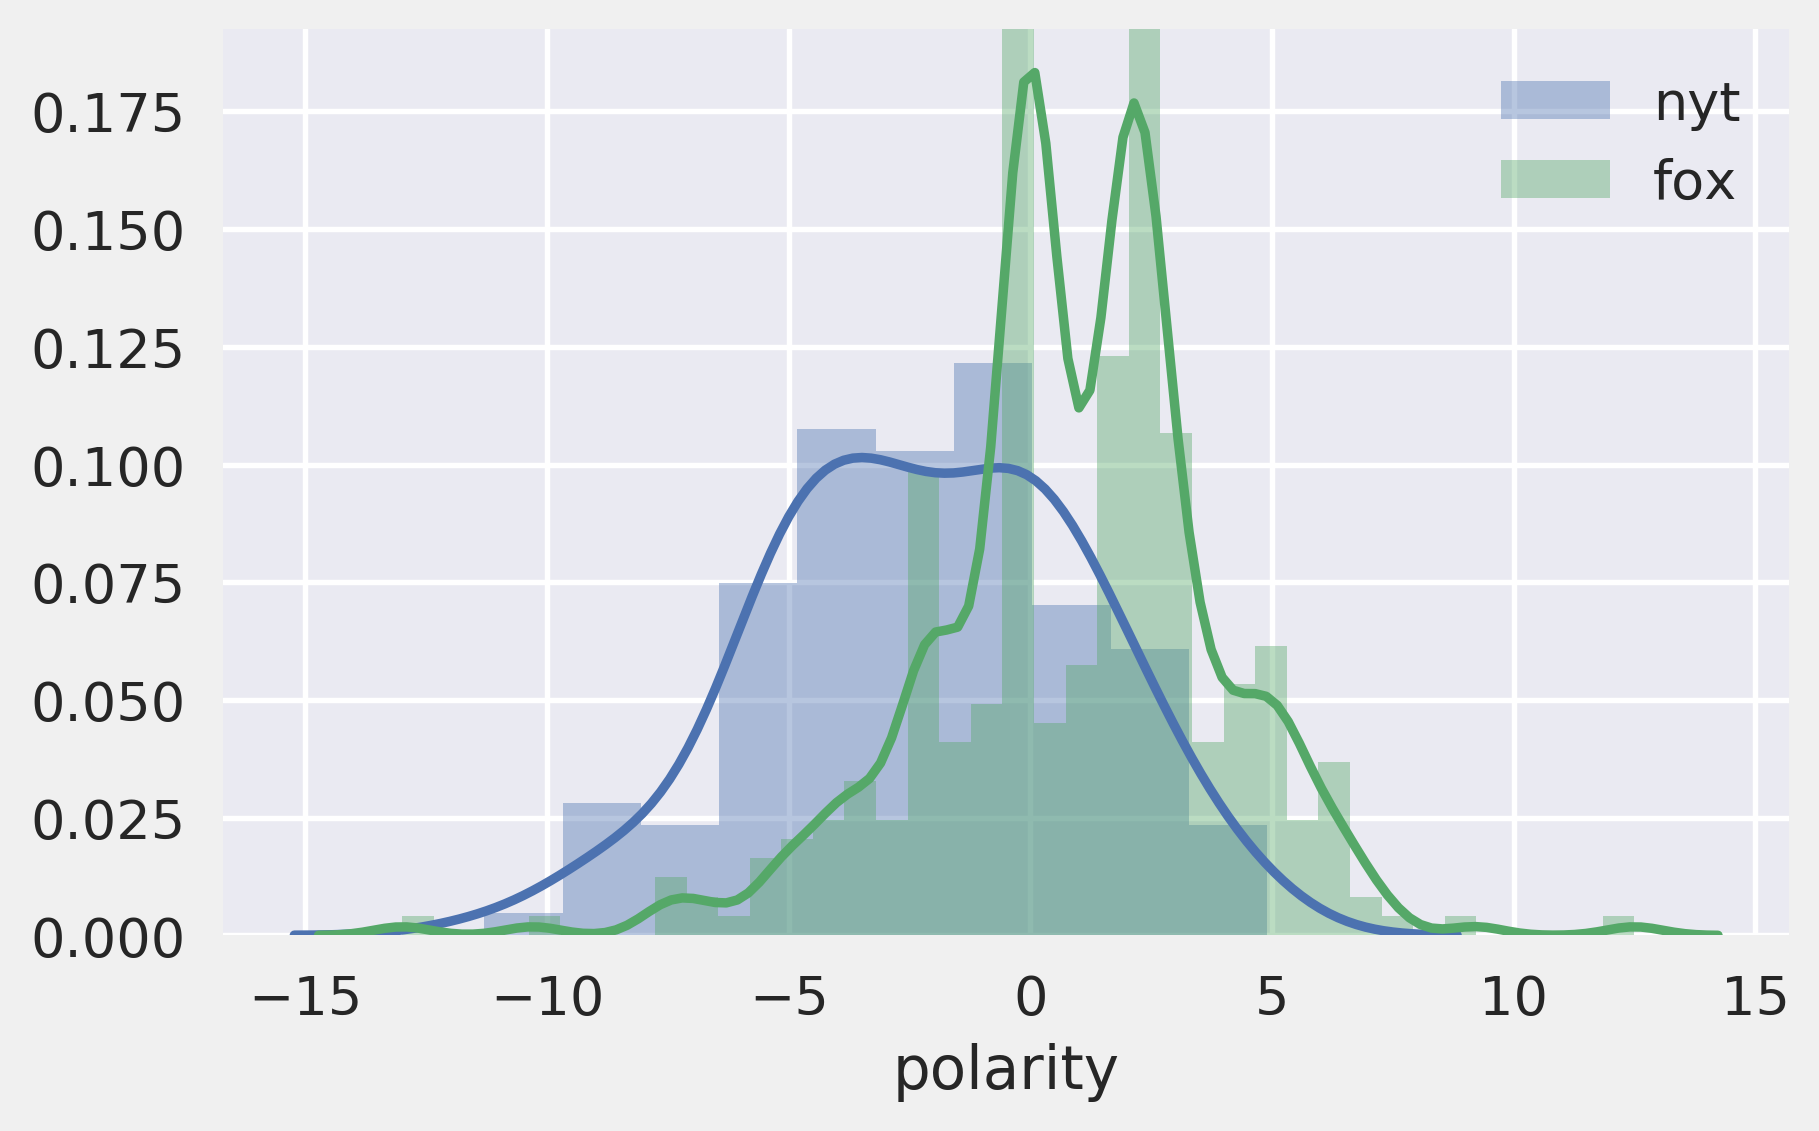

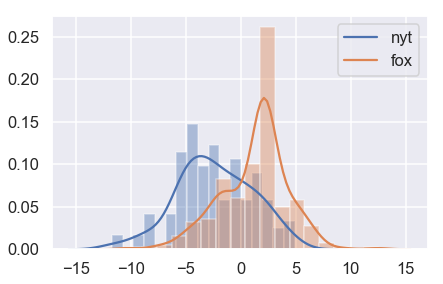

In [121]:
def contains(string, pattern):
    if  string.find(pattern) != -1       or \
        string.find(' ' + pattern) != -1 or \
        string.find(pattern + ' ') != -1 or \
        string.find(' ' + pattern + ' ') != -1: 
        return True
    else:
        return False

nyt = df_trump[df_trump['no_punc'].apply(lambda s: contains(s, 'nyt'))][['polarity']].dropna()
fox = df_trump[df_trump['no_punc'].apply(lambda s: contains(s, 'fox'))][['polarity']].dropna()

fig, ax = plt.subplots()
sns.distplot(nyt, bins=17, kde=True, hist=True, ax=ax, kde_kws={"label": "nyt"})
sns.distplot(fox, bins=17, kde=True, hist=True, ax=ax, kde_kws={"label": "fox"});

In [228]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from random import shuffle

stop_words = set(stopwords.words('english'))
other_words = set(['https', 'co', 'c', 'w', 'u', 'pm', 'clinton', 'cruz', 'obama'])
stop_words = stop_words.union(other_words)
words = tidy_format['word']
filtered_words = []

for w in words:
    if w not in stop_words:
        filtered_words.append(w)
filtered = pd.Series(filtered_words)

top50_count = filtered.value_counts()[:50]
top50 = np.array(top50_count.index.tolist())
tweets5k = np.array(df_trump.index.tolist())
shuffle(tweets5k)
tweets5k = tweets5k[:5000]
doc_freq = pd.DataFrame(data=np.arange(250000).reshape(5000,50), index=tweets5k, columns=top50)

def word_count(value, word):
    index = doc_freq[word][doc_freq[word] == value].index[0]
    try:
        return df_trump.loc[index]['no_punc'].count(word)
    except KeyError:
        return 0
    
for top_word in top50:
    doc_freq[top_word] = doc_freq[top_word].apply(lambda val: word_count(val, top_word)) 

In [204]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
doc_pca = pca.fit(doc_freq)
print(doc_pca)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


In [216]:
from sklearn.decomposition import PCA
from scipy import sparse
pca = PCA(.95)
pca.fit(doc_freq)
doc_pca = pca.transform(doc_freq)
doc_pca = pd.DataFrame(doc_pca)
sparse_doc_pca = sparse.csr_matrix(doc_pca)  

In [261]:
def avg_retweet(word):
    rt = df_trump[df_trump['no_punc'].apply(lambda x: x.find(word) >= 0)]['retweet_count']
    return (rt.sum()/len(rt))

top_20 = pd.DataFrame()
top_20['word'] = top50
top_20['retweet_count'] = top_20['word'].apply(lambda w: avg_retweet(w))
top_20 = top_20.sort_values(by="retweet_count", ascending=False).head(20).set_index('word')
print(top_20)

           retweet_count
word                    
fake        22684.113208
must        18001.979866
country     17977.096154
media       17603.161943
years       17587.055901
never       15193.364035
people      15003.704918
many        14994.576923
would       14855.386957
tax         14648.211268
bad         14582.122807
news        14547.887029
jobs        14295.177419
american    14112.263736
time        13900.269953
much        13668.358289
going       13500.336585
president   13410.912195
cnn         13363.759036
us          13051.530899


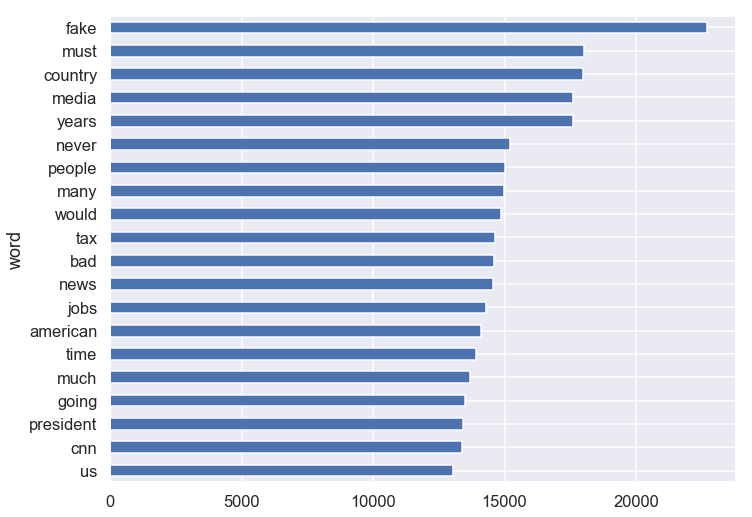

In [262]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8));